In [1]:
from preprocessing import Preprocessor
from training import Trainer
from metrics import Metrics
import torch.nn as nn
import torch.optim as optim
from models.vgg_TL import VGG, GoogleNet, ResNet
from configuration import Hyperparameters as HP
import torch

years = [str(y) for y in range(2006, 2015)]

classes = ["detritus", "Leptocylindrus", "Chaetoceros", "Rhizosolenia", "Guinardia_delicatula", "Cerataulina", "Cylindrotheca",
    "Skeletonema", "Dactyliosolen", "Thalassiosira", "Dinobryon", "Corethron", "Thalassionema", "Ditylum", "pennate", "Prorocentrum",
    "Pseudonitzschia", "Tintinnid", "Guinardia_striata", "Phaeocystis"]

all_classes = ["mix", "detritus", "Leptocylindrus", "mix_elongated", "Chaetoceros", "dino30", "Rhizosolenia", "Guinardia_delicatula", 
"Cerataulina", "Cylindrotheca", "Skeletonema", "Ciliate_mix", "Dactyliosolen", "Thalassiosira", "bad", "Dinobryon", "Corethron", 
"DactFragCerataul" "Thalassionema", "Ditylum", "pennate", "Prorocentrum", "Pseudonitzschia", "Mesodinium_sp", "G_delicatula_parasite", 
"Tintinnid", "Guinardia_striata", "Phaeocystis", "Dictyocha", "Pleurosigma", "Eucampia", "Thalassiosira_dirty", 
"Asterionellopsis", "flagellate_sp3", "Laboea_strobila", "Chaetoceros_didymus_flagellate", "Heterocapsa_triquetra", "Guinardia_flaccida", 
"Chaetoceros_pennate", "Ceratium", "Euglena", "Coscinodiscus", "Strombidium_morphotype1", "Paralia", "Gyrodinium", "Ephemera", "Pyramimonas_longicauda", 
"Proterythropsis_sp", "Gonyaulax", "kiteflagellates", "Chrysochromulina", "Chaetoceros_didymus", "bead", "Katodinium_or_Torodinium", "Leptocylindrus_mediterraneus", 
"spore", "Tontonia_gracillima", "Delphineis", "Dinophysis", "Strombidium_morphotype2", "Licmophora", "Lauderia", "clusterflagellate", "Strobilidium_morphotype1", 
"Leegaardiella_ovalis", "pennate_morphotype1", "amoeba", "Strombidium_inclinatum", "Pseudochattonella_farcimen", "Amphidinium_sp", "dino_large1", 
"Strombidium_wulffi", "Chaetoceros_flagellate", "Strombidium_oculatum", "Cerataulina_flagellate", "Emiliania_huxleyi", "Pleuronema_sp", "Strombidium_conicum",
 "Odontella", "Protoperidinium", "zooplankton", "Stephanopyxis", "Tontonia_appendiculariformis", "Strombidium_capitatum", "Bidulphia", "Euplotes_sp", 
 "Parvicorbicula_socialis", "bubble", "Hemiaulus", "Didinium_sp", "pollen", "Tiarina_fusus", "Bacillaria", "Cochlodinium", "Akashiwo", "Karenia"]

classes_30 = ["Asterionellopsis", "bad", "Chaetoceros", "Chaetoceros_flagellate", "Ciliate_mix", "Corethron", "Cylindrotheca", "Dictyocha","dino30", "detritus",
	"Dinobryon", "Ditylum", "Eucampia", "flagellate_sp3", "Guinardia_delicatula", "Guinardia_flaccida", "Guinardia_striata", "Heterocapsa_triquetra", "Laboea_strobila", "Leptocylindrus",
	"pennate", "Phaeocystis", "Pleurosigma", "Prorocentrum", "Pseudonitzschia", "Skeletonema", "Thalassionema", "Thalassiosira", "Thalassiosira_dirty", "Tintinnid"]

print(len(classes_30))


30


In [2]:

#pp = Preprocessor(years, include_classes=classes, train_eg_per_class=HP.number_of_images_per_class)
#pp = Preprocessor(years, include_classes=all_classes, train_eg_per_class=HP.number_of_images_per_class, thresholding=HP.thresholding)
pp = Preprocessor(years, include_classes=classes_30, train_eg_per_class=HP.number_of_images_per_class, thresholding=HP.thresholding, maxN = HP.maxN)


pp.create_datasets([0.6,0.2,0.2])

trainLoader = pp.get_loaders('train', HP.batch_size)
validLoader = pp.get_loaders('validation', HP.batch_size)
testLoader = pp.get_loaders('test', HP.batch_size)


trainer = Trainer(HP_version = HP.version, epochs = HP.number_of_epochs, loss_fn = HP.loss_function, 
	optimizer = HP.optimizer, scheduler = HP.scheduler, lr = HP.learning_rate, momentum = HP.momentum, useCuda=True)

model = GoogleNet()

#trainAcc, validAcc, epochs = trainer.train(model, trainLoader, validLoader, earlyStopping = HP.es)

# - or -
pth = "../GoogleNet_1.2-5.2.pth"

model = trainer.load_full_model(model, pth)

testPred, testTarget, testFnames = trainer.test(model, testLoader)
validPred, validTarget, validFnames = trainer.test(model, validLoader)
trainPred, trainTarget, trainFnames = trainer.test(model, trainLoader)


777655
99985
99985


/home/czm/saad/urfp-hab-plankton/models/vgg_TL.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [3]:
allPred = torch.cat((testPred, validPred, trainPred), 0)
allTarget = torch.cat((testTarget, validTarget, trainTarget), 0)

In [4]:
testM = Metrics(testTarget, testPred)
validM = Metrics(validTarget, validPred)
trainM = Metrics(trainTarget, trainPred)
allM = Metrics(allTarget, allPred)

In [5]:
#allM.plot_CM(preprocessor= pp)

In [6]:
#testM.sample(5, classname="Thalassiosira_dirty")

In [7]:
#testM.sample(5, classname="Thalassiosira_dirty", preprocessor=pp)

In [8]:
#testM.sample(5, fname=testFnames, classname="Thalassiosira_dirty", preprocessor=pp)

In [9]:
#testM.sample_diff(5)

In [10]:
#testM.sample_diff(5, classname=2)

In [11]:
#testM.sample_diff(5, classname="Chaetoceros_flagellate", preprocessor = pp)

['./data/2010/Chaetoceros_flagellate/IFCB5_2010_259_094055_00754.png'
 './data/2007/Chaetoceros_flagellate/IFCB1_2007_059_221306_00457.png'
 './data/2013/Chaetoceros_flagellate/IFCB5_2013_184_211057_01375.png'
 './data/2008/Chaetoceros_flagellate/IFCB1_2008_218_001524_02102.png'
 './data/2012/Chaetoceros_flagellate/IFCB1_2012_269_071532_00897.png']
['./data/2008/detritus/IFCB1_2008_213_192735_01916.png']
['./data/2010/Chaetoceros_flagellate/IFCB5_2010_259_094055_00754.png'
 './data/2008/detritus/IFCB1_2008_213_192735_01916.png'
 './data/2007/Chaetoceros_flagellate/IFCB1_2007_059_221306_00457.png'
 './data/2013/Chaetoceros_flagellate/IFCB5_2013_184_211057_01375.png'
 './data/2008/Chaetoceros_flagellate/IFCB1_2008_218_001524_02102.png'
 './data/2012/Chaetoceros_flagellate/IFCB1_2012_269_071532_00897.png']
['./data/2013/Chaetoceros/IFCB5_2013_184_213410_08050.png']
['./data/2010/Chaetoceros_flagellate/IFCB5_2010_259_094055_00754.png'
 './data/2008/detritus/IFCB1_2008_213_192735_01916.png'

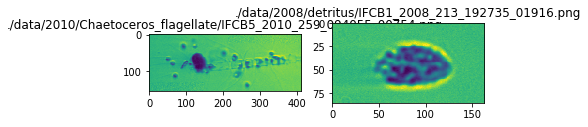

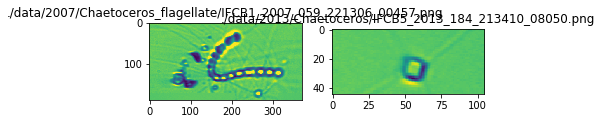

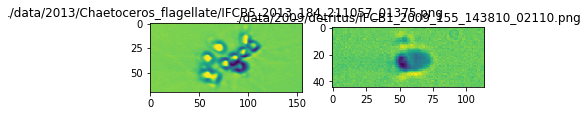

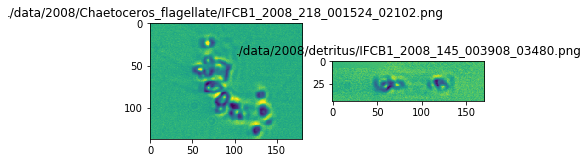

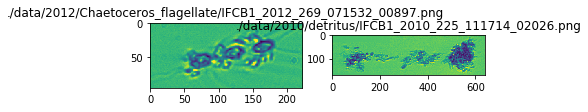

(array([2, 2, 2, 2, 2]), array([26,  1, 26, 26, 26]))

In [12]:
testM.sample_diff(5, classname="Chaetoceros_flagellate", preprocessor = pp, fname=testFnames)

In [39]:
import numpy as np
wi = np.where(np.array(testM.target) != np.array(testM.pred))[0]

wi = wi[np.where(np.array(testM.target)[wi] == 2)[0]]

ri = np.random.choice(wi, size = 5, replace = False)
ta = np.array(testM.target)[ri]
pa = np.array(testM.pred)[ri]



In [40]:
indxs = np.where(np.array(testM.target)==pa[0])[0]
pred_img = np.array(testFnames)[np.random.choice(indxs, size = 1)]

In [41]:
pred_img

array(['./data/2006/detritus/IFCB1_2006_191_001242_01676.png'],
      dtype='<U66')

In [ ]:
testM.sample_diff(5, classname="Thalassiosira_dirty", preprocessor = pp)

In [ ]:
testM.sample_diff(5, fname = testFnames, classname="Thalassiosira_dirty", preprocessor = pp)

In [7]:
pp.onehotInd_to_label(26)

'detritus'

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform

In [8]:
fnames = ['./data/2009/detritus/IFCB1_2009_158_180517_02147.png', './data/2011/Leptocylindrus/IFCB1_2011_279_221512_03569.png', './data/2010/Leptocylindrus/IFCB1_2010_036_175129_01619.png', './data/2011/dino30/IFCB1_2011_218_200940_06267.png', './data/2014/Cylindrotheca/IFCB5_2014_060_062630_02950.png', './data/2006/Leptocylindrus/IFCB1_2006_272_000827_03201.png', './data/2013/detritus/IFCB5_2013_113_104613_00525.png', './data/2012/dino30/IFCB5_2012_039_201905_01802.png', './data/2006/detritus/IFCB1_2006_172_174135_03962.png']


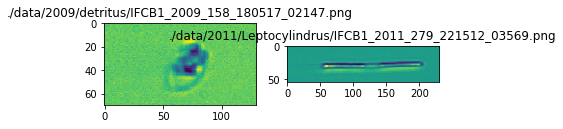

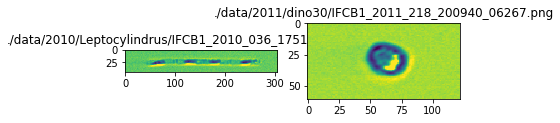

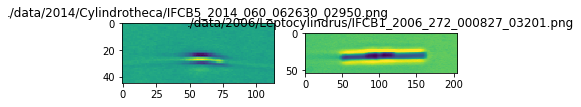

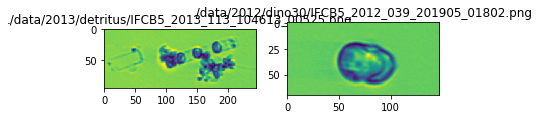

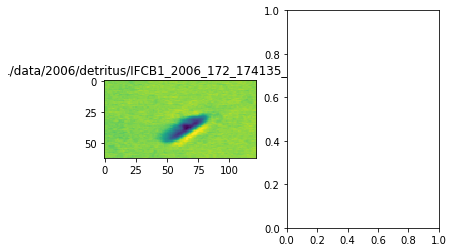

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2)
c=0
for fname in fnames:
    img = io.imread(fname)
    if c %2 == 0:
        ax1.imshow(img)
        ax1.set_title(fname)
    else:
        ax2.imshow(img)
        ax2.set_title(fname)
        fig, (ax1, ax2) = plt.subplots(1,2)
    c+=1
plt.show()

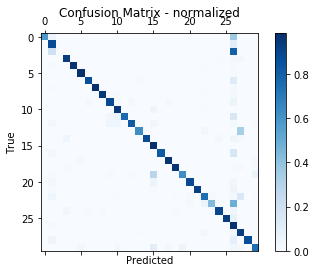

In [8]:
testM.plot_CM()

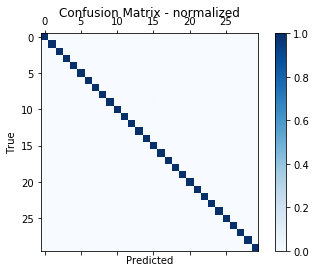

In [9]:
trainM.plot_CM()

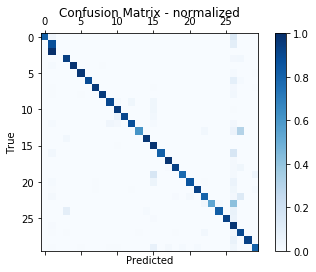

In [10]:
validM.plot_CM()

In [4]:
test_pred, test_target = testPred, testTarget
valid_pred, valid_target = validPred, validTarget
train_pred, train_target = trainPred, trainTarget

In [5]:
f= open("predtarget-"+str(model)+"-"+str(HP.version)+".json","w+")
str_to_write = "{\"Train_Pred\": " + str(list(train_pred.cpu().numpy())) + ", \"Train_Target\": " + str(list(train_target.cpu().numpy())) + ", \"Valid_Pred\": " + str(list(valid_pred.cpu().numpy())) + ", \"Valid_Target\": " + str(list(valid_target.cpu().numpy())) + ", \"Test_Pred\": " + str(list(test_pred.cpu().numpy())) + ", \"Test_Target\": " + str(list(test_target.cpu().numpy())) + "}"
f.write(str_to_write)
f.close()

In [5]:
uniq_classes = set(target.tolist())
class_names = []
for cl in uniq_classes:
    print(cl)
    class_names.append(pp.onehot_to_label(cl))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [9]:
from sklearn.metrics import classification_report
ca_dic = classification_report(target.tolist(), pred.tolist(), target_names=class_names, output_dict=True)

In [10]:
ca_dic

{'Asterionellopsis': {'precision': 0.4,
  'recall': 1.0,
  'f1-score': 0.5714285714285715,
  'support': 22},
 'Chaetoceros': {'precision': 0.7982005141388174,
  'recall': 0.914580265095729,
  'f1-score': 0.852436513383665,
  'support': 679},
 'Chaetoceros_flagellate': {'precision': 0.3333333333333333,
  'recall': 1.0,
  'f1-score': 0.5,
  'support': 3},
 'Ciliate_mix': {'precision': 0.9282511210762332,
  'recall': 0.9627906976744186,
  'f1-score': 0.9452054794520549,
  'support': 215},
 'Corethron': {'precision': 0.8876404494382022,
  'recall': 1.0,
  'f1-score': 0.9404761904761905,
  'support': 79},
 'Cylindrotheca': {'precision': 0.963855421686747,
  'recall': 0.995850622406639,
  'f1-score': 0.979591836734694,
  'support': 241},
 'Dictyocha': {'precision': 0.7741935483870968,
  'recall': 1.0,
  'f1-score': 0.8727272727272727,
  'support': 24},
 'Dinobryon': {'precision': 0.9256198347107438,
  'recall': 0.9824561403508771,
  'f1-score': 0.9531914893617021,
  'support': 114},
 'Ditylu

In [ ]:

#f= open("stats-"+str(model)+"-"+str(HP.version)+".json","w+")
str_to_write = "{\"Epochs\": "+str(epochs)+ ", \"TrainAcc\": "+ str(trainAcc)+", \"ValidAcc\": "+str(validAcc)+", \"TestAcc\": "+str(met.accuracy())+"}"
#str_to_write = "{\"Pred\": "+str(list(pred.cpu().numpy()))+", \"Target\": "+str(list(target.cpu().numpy()))+"}"
f.write(str_to_write)
f.close()


In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg',0)
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

ImportError: dlopen(/Users/saadghani/Development/miniconda3/envs/URFP_Plankton/lib/python3.7/site-packages/cv2.cpython-37m-darwin.so, 2): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: /Users/saadghani/Development/miniconda3/envs/URFP_Plankton/lib/libopencv_imgcodecs.4.1.dylib
  Reason: Incompatible library version: libopencv_imgcodecs.4.1.dylib requires version 13.0.0 or later, but libjpeg.9.dylib provides version 12.0.0

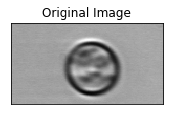

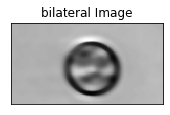

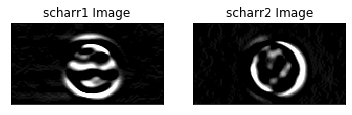

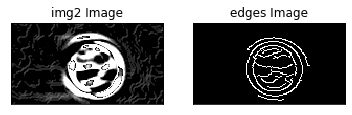

In [123]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('data/2006/Thalassiosira/IFCB1_2006_158_000036_00309.png',0)

edges = cv2.Canny(img,20,100)

bilateral = cv2.bilateralFilter(img, 9,75,75) # 9,75,75 
scharr1 = cv2.Scharr(bilateral, -1, 0, 1) # (src, ddepth, dx, dy[, dst[, scale[, delta[, borderType]]]])
scharr2 = cv2.Scharr(bilateral, -1, 1, 0) # (src, ddepth, dx, dy[, dst[, scale[, delta[, borderType]]]])


img1 = scharr1 + scharr2 

  


def contrast_increaser(x):
    if x > 10:
        x = x*2.5
        if x > 255:
            x = 255
    else:
        x = x*0.4
    return x

cf = np.vectorize(contrast_increaser)
img2 = cf(img1)




In [3]:
from torchvision import models
m = models.resnet50()
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [2]:
m.fc

Linear(in_features=512, out_features=1000, bias=True)